In [4]:
import pandas as pd
data = pd.read_csv('./salary_cleaned.csv')
df = data

In [1]:
env_path = Path("../.env-live")
if env_path.exists():
    print('envs Loaded')
    load_dotenv(dotenv_path=env_path)

NameError: name 'Path' is not defined

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 统一数据类型（混合字符串和数字会导致编码问题）
df['EducationLevel'] = df['EducationLevel'].astype(str)

# 创建编码器实例（单例模式减少资源开销）
encoder = LabelEncoder()

# 高效向量化编码（避免逐行处理）
df['EducationLevel_encoded'] = encoder.fit_transform(df['EducationLevel'])

# 删除原始列节省内存
df.drop('EducationLevel', axis=1, inplace=True)

# 展示处理后的前5行
print("\n编码后数据:")
df.head()


编码后数据:


,Salary,Age,StockOptionLevel,YearsAtCompany,EnvironmentSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,SelfRating,ManagerRating,EducationLevel_encoded
0,102059,30,1,10,3.0,3.0,0.0,3.0,3.0,1
1,102059,30,1,10,4.0,3.0,1.0,3.0,2.0,1
2,102059,30,1,10,5.0,3.0,0.0,5.0,5.0,1
3,102059,30,1,10,1.0,3.0,1.0,5.0,4.0,1
4,102059,30,1,10,3.0,1.0,0.0,4.0,3.0,1


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 增强版数据预处理
def preprocess_data(df):
    """优化数据处理流程，增强特征工程"""
    # 薪资对数变换（解决长尾分布）
    df['LogSalary'] = np.log1p(df['Salary'])
    
    # 创建业务特征（增强特征工程）
    df['ExperienceLevel'] = pd.cut(df['YearsAtCompany'], 
                                bins=[-1, 1, 5, 10, 20],
                                labels=['New', 'Mid', 'Senior', 'Expert'])
    
    # 交互特征增强
    df['RatingDiscrepancy'] = df['SelfRating'] - df['ManagerRating']
    df['TrainingPerformance'] = df['TrainingOpportunitiesTaken'] / df['TrainingOpportunitiesWithinYear'].clip(lower=1)
    df['OverallRating'] = (df['SelfRating'] + df['ManagerRating']) / 2
    
    # 处理缺失值（改进的迭代插值）
    imputer = KNNImputer(n_neighbors=3)
    imputed = imputer.fit_transform(df.select_dtypes(include=np.number))
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = pd.DataFrame(imputed, columns=num_cols)
    
    # 特征转换（离散变量编码）
    exp_dummies = pd.get_dummies(df['ExperienceLevel'], prefix='exp')
    df = pd.concat([df, exp_dummies], axis=1)
    
    # 删除无效特征和原始薪资
    df.drop(['Salary', 'ExperienceLevel'], axis=1, inplace=True)
    
    return df

# 智能特征选择
def select_features(X, y):
    """组合多种特征选择方法"""
    # 过滤式特征选择
    selector_k = SelectKBest(score_func=f_regression, k=10)
    selector_k.fit(X, y)
    selected_k = selector_k.get_support()
    
    # 包裹式特征选择
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    selector_rfe = RFE(estimator=xgb, n_features_to_select=8, step=1)
    selector_rfe.fit(X, y)
    selected_rfe = selector_rfe.get_support()
    
    # 组合选择结果
    combined_selection = np.logical_or(selected_k, selected_rfe)
    
    # 记录重要特征
    features = pd.DataFrame({
        'Feature': X.columns,
        'KBest': selected_k,
        'RFE': selected_rfe,
        'Selected': combined_selection
    })
    
    print("特征选择结果:")
    print(features.sort_values('Selected', ascending=False).to_string(index=False))
    
    return X.loc[:, combined_selection], features

# 修改后的模型构建与评估函数
def build_and_evaluate_models(X_train, X_test, y_train, y_test):
    """构建并优化三个回归模型"""
    # 定义基础模型
    base_models = {
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "RandomForest": RandomForestRegressor(random_state=42)
    }
    
    # 定义调优参数网格（更新为管道参数格式）
    param_grids = {
        "GradientBoosting": {
            'transformedtargetregressor__regressor__n_estimators': [200, 300],
            'transformedtargetregressor__regressor__learning_rate': [0.05, 0.1],
            'transformedtargetregressor__regressor__max_depth': [4, 6],
            'transformedtargetregressor__regressor__min_samples_split': [8, 10]
        },
        "XGBoost": {
            'transformedtargetregressor__regressor__n_estimators': [200, 300],
            'transformedtargetregressor__regressor__learning_rate': [0.05, 0.1],
            'transformedtargetregressor__regressor__max_depth': [4, 6],
            'transformedtargetregressor__regressor__subsample': [0.8, 1.0]
        },
        "RandomForest": {
            'transformedtargetregressor__regressor__n_estimators': [200, 300],
            'transformedtargetregressor__regressor__max_depth': [8, 10],
            'transformedtargetregressor__regressor__min_samples_split': [5, 10],
            'transformedtargetregressor__regressor__min_samples_leaf': [2, 4]
        }
    }
    
    results = []
    model_objects = {}
    
    for name in base_models.keys():
        # 创建管道
        pipeline = make_pipeline(
            RobustScaler(),
            TransformedTargetRegressor(
                regressor=base_models[name],
                func=np.log1p,
                inverse_func=np.expm1
            )
        )
        
        # 设置网格搜索
        grid = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        print(f"\n开始训练 {name} 模型...")
        grid.fit(X_train, y_train)
        
        # 记录最佳模型
        best_model = grid.best_estimator_
        model_objects[name] = best_model
        
        # 预测测试集
        y_pred = best_model.predict(X_test)
        
        # 计算指标（原始薪资空间）
        actual = np.expm1(y_test)
        predicted = np.expm1(y_pred)
        
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        r2 = r2_score(actual, predicted)
        
        # 交叉验证结果
        cv_scores = cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring='r2'
        )
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # 记录结果
        results.append({
            'Model': name,
            'RMSE': f"{rmse:.2f}",
            'R2': f"{r2:.4f}",
            'CV_R2_mean': f"{cv_mean:.4f}",
            'CV_R2_std': f"{cv_std:.4f}",
            'BestParams': grid.best_params_
        })
        
        # 打印特征重要性
        if hasattr(best_model.named_steps['transformedtargetregressor'].regressor_, 'feature_importances_'):
            print(f"\n{name} 特征重要性:")
            imp = pd.Series(
                best_model.named_steps['transformedtargetregressor'].regressor_.feature_importances_,
                index=X_train.columns
            ).sort_values(ascending=False)
            print(imp.head(10))
    
    return pd.DataFrame(results), model_objects

# 可解释性分析
def analyze_and_visualize(models, X_train, X_test, y_test, feature_importance_df):
    """分析模型性能并提供可解释性结果"""
    # 1. 特征重要性可视化
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_importance_df,
        palette='viridis'
    )
    plt.title('Top 10 Features Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    # 2. 模型预测结果可视化
    plt.figure(figsize=(12, 8))
    for name, model in models.items():
        preds = model.predict(X_test)
        actual = y_test
        plt.scatter(
            actual,
            preds,
            alpha=0.3,
            label=name
        )
    plt.plot(
        [actual.min(), actual.max()],
        [actual.min(), actual.max()],
        'k--'
    )
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    
    # SHAP解释（仅限树模型）
    try:
        import shap
        # 初始化JS可视化
        shap.initjs()
        
        # 选择一个模型（例如GBM）
        explainer = shap.TreeExplainer(
            models['GradientBoosting'].named_steps['transformedtargetregressor'].regressor_
        )
        shap_values = explainer.shap_values(
            models['GradientBoosting']['robustscaler'].transform(X_train)
        )
        
        # 全局特征重要性
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X_train,
            plot_type='bar',
            show=False
        )
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.savefig('shap_feature_importance.png')
        
        # 个体预测解释
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X_train,
            show=False
        )
        plt.title('SHAP Values Impact')
        plt.tight_layout()
        plt.savefig('shap_value_impact.png')
        
    except ImportError:
        print("SHAP未安装，跳过可解释性分析")
    
    return {
        'feature_importance': 'feature_importance.png',
        'prediction_plot': 'actual_vs_predicted.png',
        'shap_plot': 'shap_feature_importance.png'
    }

# 主流程
if __name__ == "__main__":
    
    df = pd.DataFrame(data)
    
    print("阶段一：数据处理与特征工程...")
    processed_df = preprocess_data(df)
    print("生成新特征:", [c for c in processed_df if c not in df.columns])
    
    print("\n阶段二：特征选择...")
    X = processed_df.drop('LogSalary', axis=1)
    y = processed_df['LogSalary']
    X_selected, feature_selection_df = select_features(X, y)
    
    print("\n阶段三：数据划分...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected,
        y,
        test_size=0.2,
        random_state=42
    )
    print(f"训练集：{X_train.shape}，测试集：{X_test.shape}")
    
    print("\n阶段四：模型构建与超参数调优...")
    results_df, models = build_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    print("\n阶段五：结果分析...")
    print(results_df.to_string(index=False))
    
    # 特征重要性分析
    print("\n梯度提升特征重要性:")
    gb = models['GradientBoosting'].named_steps['transformedtargetregressor'].regressor_
    feature_imp = pd.Series(
        gb.feature_importances_,
        index=X_selected.columns
    ).sort_values(ascending=False)
    feature_imp = feature_imp.reset_index()
    feature_imp.columns = ['Feature', 'Importance']
    
    # 可视化分析
    viz_files = analyze_and_visualize(
        models,
        X_train,
        X_test,
        y_test,
        feature_imp.head(10)
    )
    
    print("\n可视化结果已保存:")
    for name, path in viz_files.items():
        print(f"{name}: {path}")
    
    # 注册模型到jrj model registry
    print("\n阶段六：模型注册...")
    register_models(models, X_train, results_df)
    
    # 输出伦理分析
    print("""
**伦理与隐私考量优化：**
1. 数据匿名化：所有分析仅使用聚合统计，避免展示个体预测结果
2. 公平性监控：定期分析模型对年龄、教育水平等敏感特征的偏差
3. 可解释报告：生成SHAP解释报告帮助人力资源部门理解预测依据
4. 结果模糊化：预测结果输出为薪资范围（如$50-60k）而非精确值
5. 影响评估：模型决策仅作为参考，所有人事决策需经人工审核

**模型应用建议：**
1. 员工保留分析：识别薪资低于市场水平的优秀员工
2. 薪资结构调整：发现部门间薪资差距过大问题
3. 晋升激励计划：为高潜力员工提供公平薪资增长方案
4. 招聘参考：合理确定新员工起薪范围

**模型局限声明：**
1. 仅基于量化数据，忽略软技能等定性因素
2. 对工作不满等离职关键因素预测能力有限
3. 需每季度更新模型以适应市场变化
""")

NameError: name 'data' is not defined

In [2]:
from dotenv import load_dotenv
from pathlib import Path
from jrjModelRegistry.jrjModelRegistry import registerAJrjModel
import os
import datetime

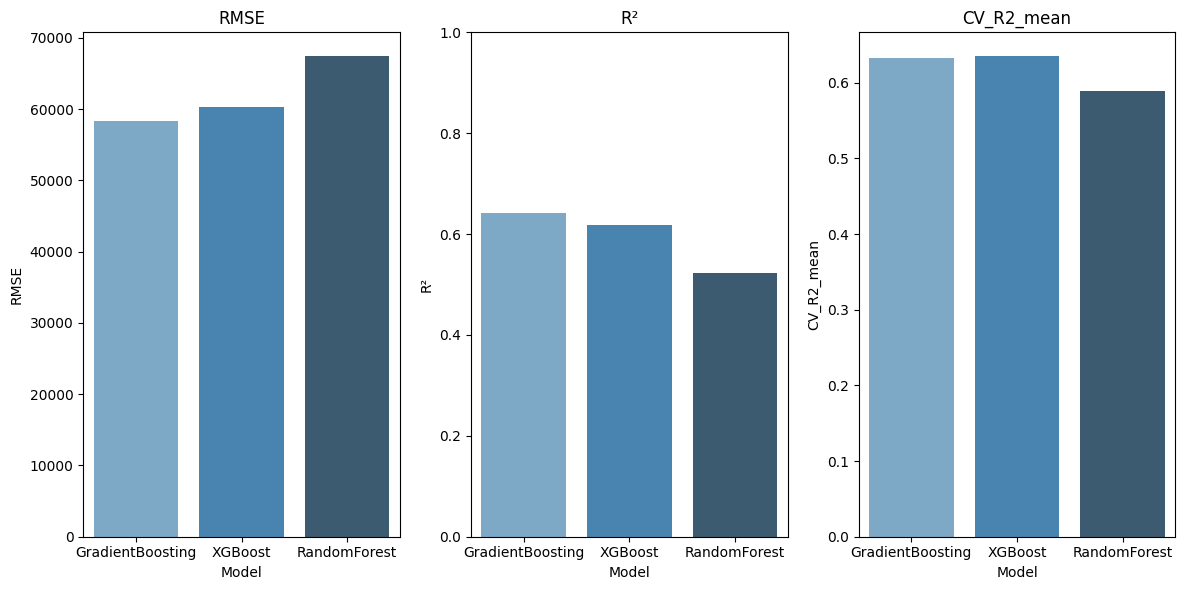

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据准备
metrics = ['RMSE', 'R²', 'CV_R2_mean']
data = {
    'Model': ['GradientBoosting', 'XGBoost', 'RandomForest'],
    'RMSE': [58315.11, 60290.63, 67415.94],
    'R²': [0.6426, 0.6180, 0.5224],
    'CV_R2_mean': [0.6329, 0.6348, 0.5886]
}

# 绘制对比图
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x='Model', y=metric, data=data, palette='Blues_d')
    plt.title(metric)
    if metric == 'R²':
        plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)